# Evaluate

This notebook evaluates the network trained previous notebooks and analyzes the results.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

In [2]:
# Load some packages
import os
import json
import yaml
from copy import deepcopy

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pprint
import matplotlib.pyplot as plt

# custom package
from datasets.caueeg_dataset import *
from datasets.caueeg_script import *
import models
from train import *

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0+cu113
cuda is available.


-----

## Load the configuration used during the train phase

In [4]:
model_name = 'idzybv9z'
model_path = os.path.join('local/checkpoint_temp', model_name, 'last_checkpoint.pt')

ckpt = torch.load(model_path)
print(ckpt.keys())

dict_keys(['model_state', 'config', 'optimizer', 'scheduler'])


In [5]:
model_state = ckpt['model_state']
config = ckpt['config']
optimizer = ckpt['optimizer']
scheduler = ckpt['scheduler']

In [6]:
pprint.pprint(config, width=250)

{'EKG': 'X',
 'LR': 0.005063820137572124,
 'activation': 'relu',
 'age_mean': tensor([71.3524]),
 'age_std': tensor([9.7340]),
 'awgn': 0.2899084282103091,
 'awgn_age': 0.16999324528091345,
 'base_channels': 64,
 'base_stride': 3,
 'block': <class 'models.resnet_2d.BasicBlock2D'>,
 'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'conv_layers': [2, 2, 2, 2],
 'criterion': 'cross-entropy',
 'crop_length': 3000,
 'crop_multiple': 2,
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/02_Curated_Data_220416/',
 'device': device(type='cuda'),
 'draw_result': True,
 'dropout': 0.450068171063315,
 'fc_stages': 1,
 'file_format': 'memmap',
 'final_pool': 'max',
 'final_shape': torch.Size([64, 512, 4, 2]),
 'first_dilation': 1,
 'generator': <class 'models.resnet_2d.ResNet2D'>,
 'history_interval': 250,
 'in_channels': 40,
 'input_norm': 'dataset',
 'iterations': 125000,
 'latency': 2000,
 'load_event': False,

-----

## Load the target model

In [7]:
model = config['generator'](**config).to(device)
model.load_state_dict(model_state)

<All keys matched successfully>

-----

## Evaluate the model and analyze the performance by the crop timing

In [8]:
@torch.no_grad()
def check_accuracy_extended_debug(model, loader, preprocess, config, repeat=1):
    model.eval()

    # for accuracy
    correct, total = (0, 0)

    # for confusion matrix
    C = config['out_dims']
    confusion_matrix = np.zeros((C, C), dtype=np.int32)

    # for error table
    error_table = {data['serial']: {'GT': data['class_label'].item(),
                                    'Pred': [0] * C} for data in loader.dataset}

    # for crop timing
    crop_timing = dict()

    # for ROC curve
    score = None
    target = None

    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in loader:
                # preprocessing (this includes to-device operation)
                preprocess(sample_batched)

                # apply model on whole batch directly on device
                x = sample_batched['signal']
                age = sample_batched['age']
                y = sample_batched['class_label']
                output = model(x, age)

                if config['criterion'] == 'cross-entropy':
                    s = F.softmax(output, dim=1)
                elif config['criterion'] == 'multi-bce':
                    s = torch.sigmoid(output)

                # calculate accuracy
                pred = s.argmax(dim=-1)
                correct += pred.squeeze().eq(y).sum().item()
                total += pred.shape[0]

                if score is None:
                    score = s.detach().cpu().numpy()
                    target = y.detach().cpu().numpy()
                else:
                    score = np.concatenate((score, s.detach().cpu().numpy()), axis=0)
                    target = np.concatenate((target, y.detach().cpu().numpy()), axis=0)

                # confusion matrix
                confusion_matrix += calculate_confusion_matrix(pred, y, num_classes=config['out_dims'])

                # error table
                for n in range(pred.shape[0]):
                    serial = sample_batched['serial'][n]
                    error_table[serial]['Pred'][pred[n].item()] += 1

                # crop timing
                for n in range(pred.shape[0]):
                    ct = sample_batched['crop_timing'][n]

                    if ct not in crop_timing.keys():
                        crop_timing[ct] = {}

                    if pred[n] == y[n]:
                        crop_timing[ct]['correct'] = crop_timing[ct].get('correct', 0) + 1
                    else:
                        crop_timing[ct]['incorrect'] = crop_timing[ct].get('incorrect', 0) + 1

    # error table update
    error_table_serial = []
    error_table_pred = []
    error_table_gt = []

    for serial in sorted(error_table.keys()):
        error_table_serial.append(serial)
        error_table_pred.append(error_table[serial]['Pred'])
        error_table_gt.append(error_table[serial]['GT'])

    error_table = {'Serial': error_table_serial,
                   'Pred': error_table_pred,
                   'GT': error_table_gt}

    accuracy = 100.0 * correct / total
    return accuracy, score, target, confusion_matrix, error_table, crop_timing

### Configurations

In [9]:
config = ckpt['config']

config['crop_timing_analysis'] = True
config['eval'] = True
config['device'] = device

repeat = round(50 / config['crop_multiple'])

train_loader, val_loader, test_loader, longer_test_loader = build_dataset_for_train(config, verbose=True)

transform: Compose(
    EegRandomCrop(crop_length=3000, length_limit=10000000, multiple=2, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[19])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------

transform_longer: Compose(
    EegRandomCrop(crop_length=12000, length_limit=10000000, multiple=2, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[19])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------


task config:
{'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'task_description': 'Classification of [Normal], [MCI], and [Dementia] '
                     'symptoms.',
 'task_name': 'CAUEEG-task1 benchmark'}

 ---------------------------------------------------------------------------------------------------- 

train_dataset[0].keys():
dict_keys([

### Train set

In [10]:
_ = check_accuracy_extended_debug(model, train_loader, config['preprocess_test'], config, repeat=repeat)
train_acc = _[0]
train_score = _[1]
train_target = _[2]
train_confusion = _[3]
train_error_table = _[4]
train_crop_timing = _[5]

print(train_acc)

87.75431034482759


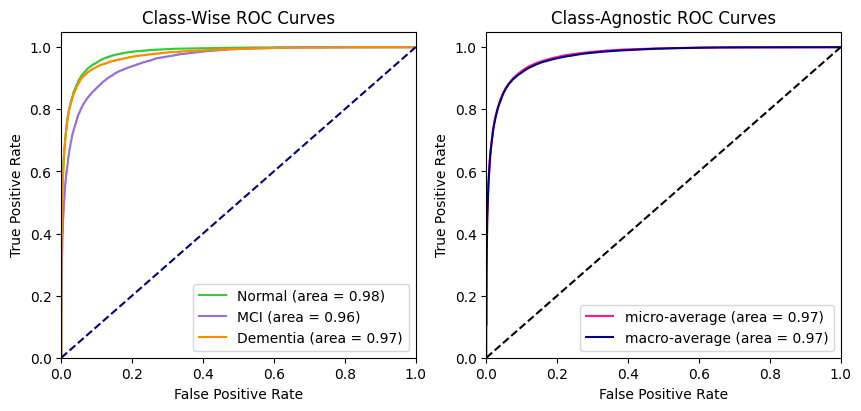

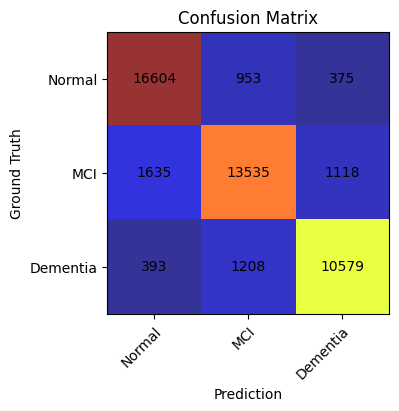

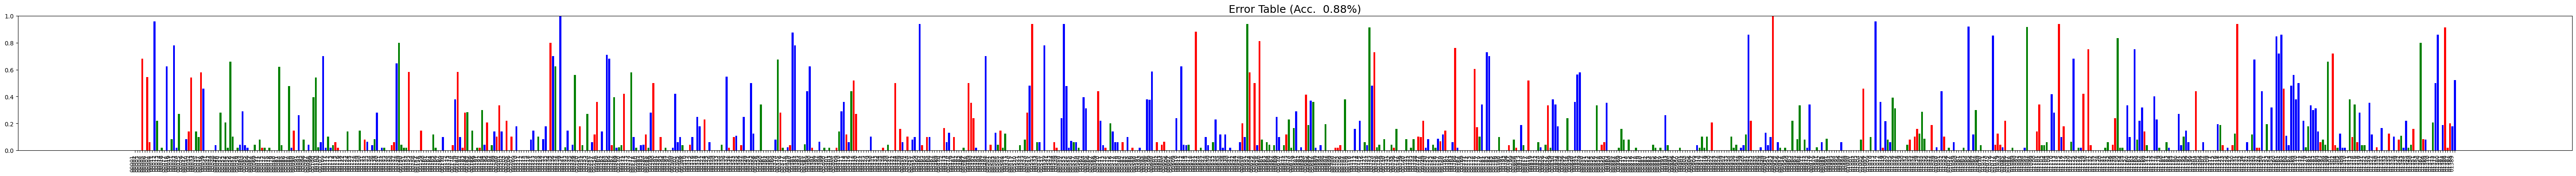

In [11]:
draw_roc_curve(train_score, train_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(train_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(train_error_table, use_wandb=False, fig_size=(60.0, 4.0))

### Validation set

In [12]:
_ = check_accuracy_extended_debug(model, val_loader, config['preprocess_test'], config, repeat=repeat)
val_acc = _[0]
val_score = _[1]
val_target = _[2]
val_confusion = _[3]
val_error_table = _[4]
val_crop_timing = _[5]

print(val_acc)

59.12605042016807


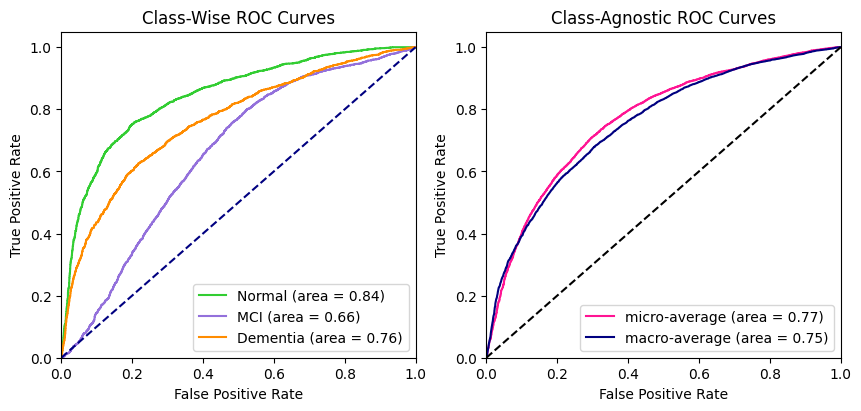

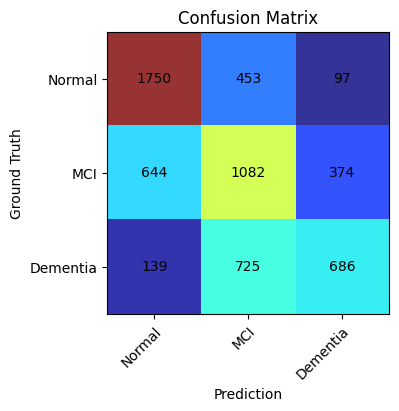

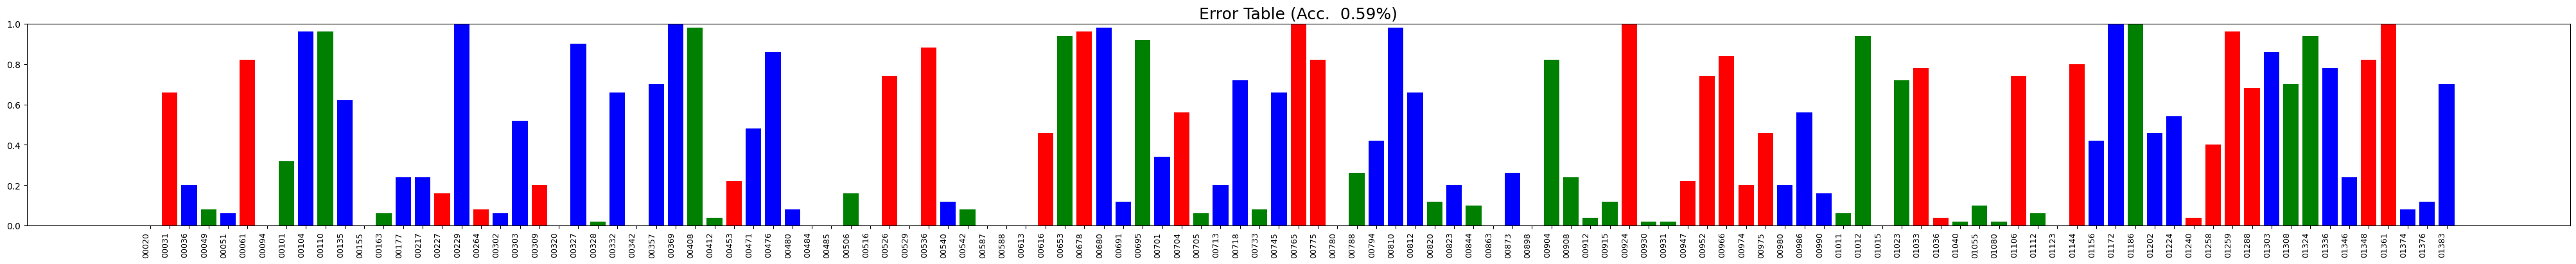

In [13]:
draw_roc_curve(val_score, val_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(val_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(val_error_table, use_wandb=False)

### Test set

In [14]:
_ = check_accuracy_extended_debug(model, test_loader, config['preprocess_test'], config, repeat=repeat)
test_acc = _[0]
test_score = _[1]
test_target = _[2]
test_confusion = _[3]
test_error_table = _[4]
test_crop_timing = _[5]

print(test_acc)

65.12605042016807


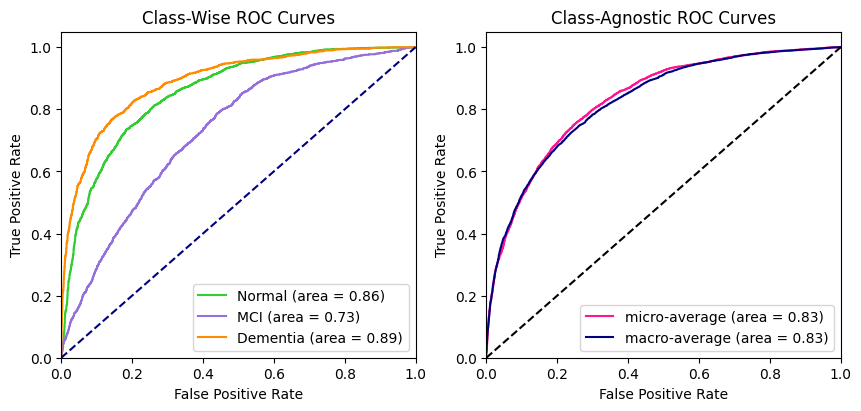

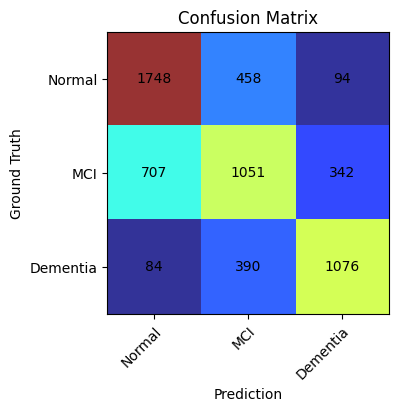

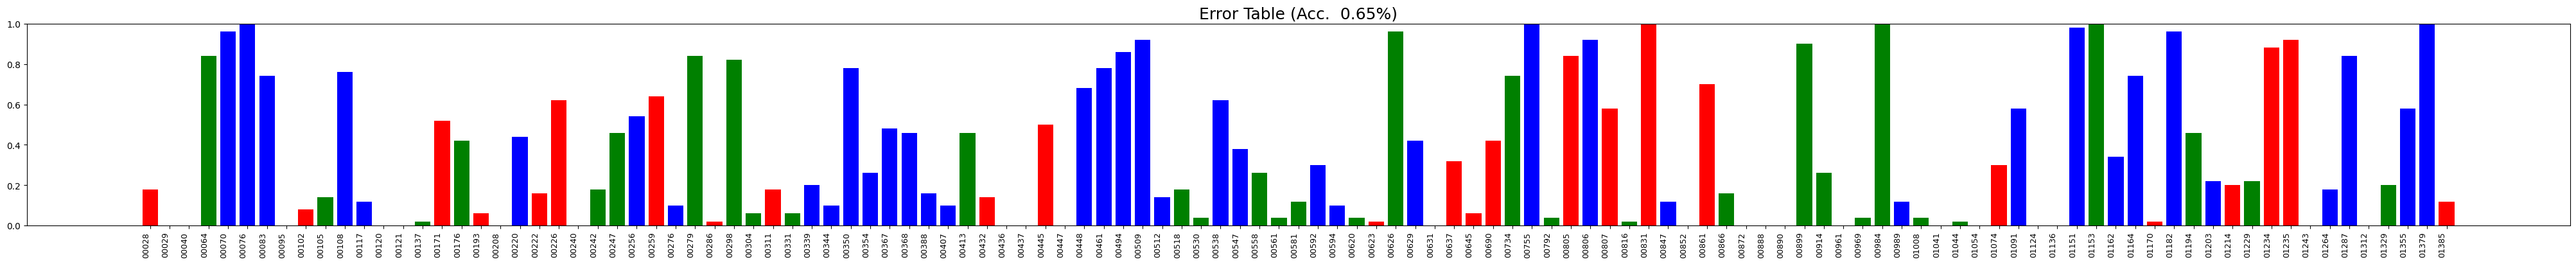

In [15]:
draw_roc_curve(test_score, test_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(test_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(test_error_table, use_wandb=False)

### Test set (with test-time augmentation)

In [16]:
_ = check_accuracy_extended_debug(model, longer_test_loader, config['preprocess_test'], config, repeat=repeat)
longer_test_acc = _[0]
longer_test_score = _[1]
longer_test_target = _[2]
longer_test_confusion = _[3]
longer_test_error_table = _[4]
longer_test_crop_timing = _[5]

print(longer_test_acc)

67.15966386554622


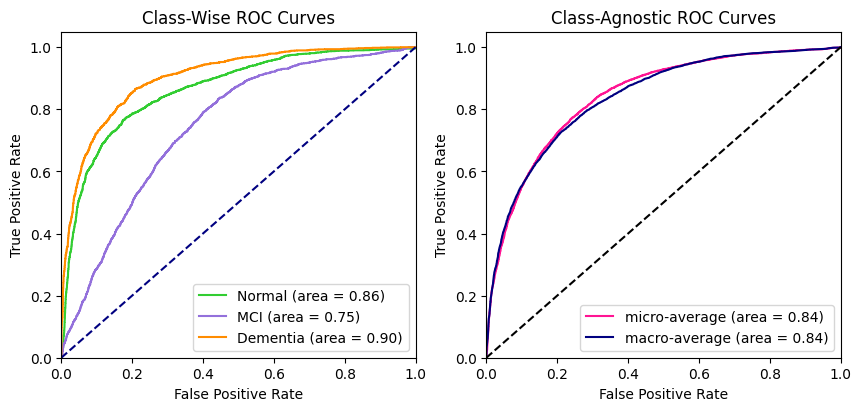

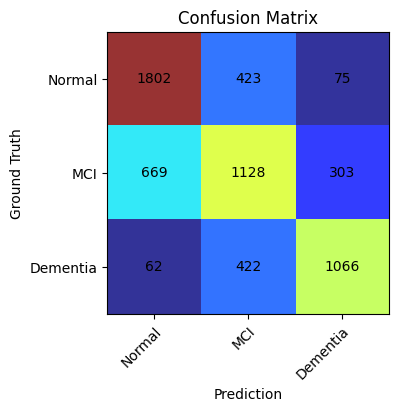

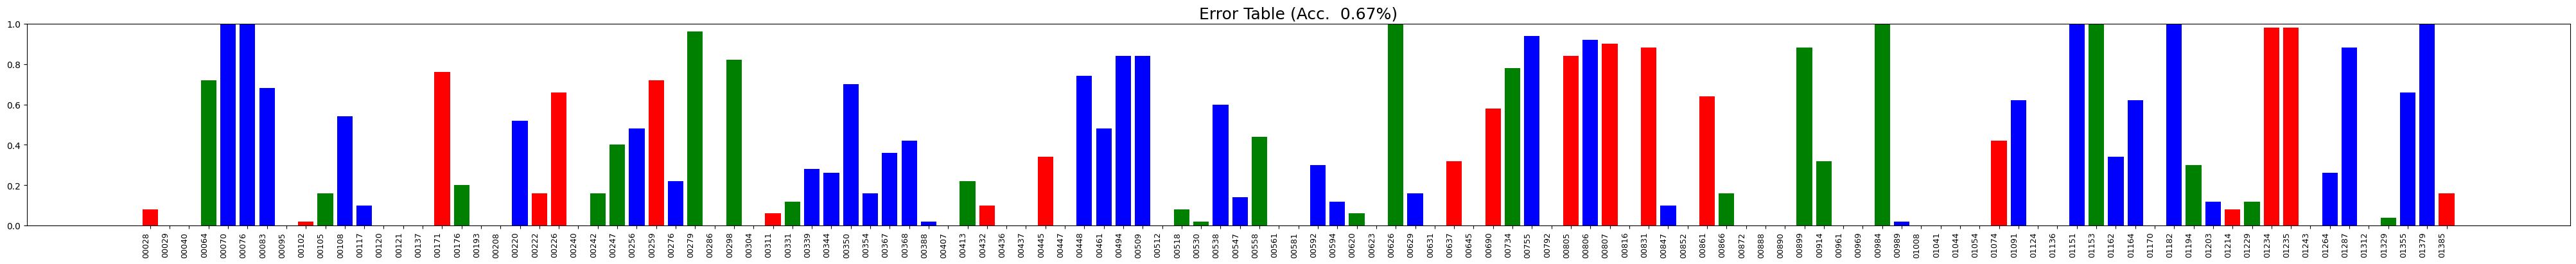

In [17]:
draw_roc_curve(longer_test_score, longer_test_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(longer_test_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(longer_test_error_table, use_wandb=False)

### Examine whether the model has a bias related to the cropping starting time

In [18]:
train_pos = []
train_neg = []

for k, v in train_crop_timing.items():
    for i in range(v.get('correct', 0)):
        train_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        train_neg.append(k)

##

val_pos = []
val_neg = []

for k, v in val_crop_timing.items():
    for i in range(v.get('correct', 0)):
        val_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        val_neg.append(k)

##

test_pos = []
test_neg = []

for k, v in test_crop_timing.items():
    for i in range(v.get('correct', 0)):
        test_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        test_neg.append(k)
        
##
        
longer_test_pos = []
longer_test_neg = []

for k, v in longer_test_crop_timing.items():
    for i in range(v.get('correct', 0)):
        longer_test_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        longer_test_neg.append(k)

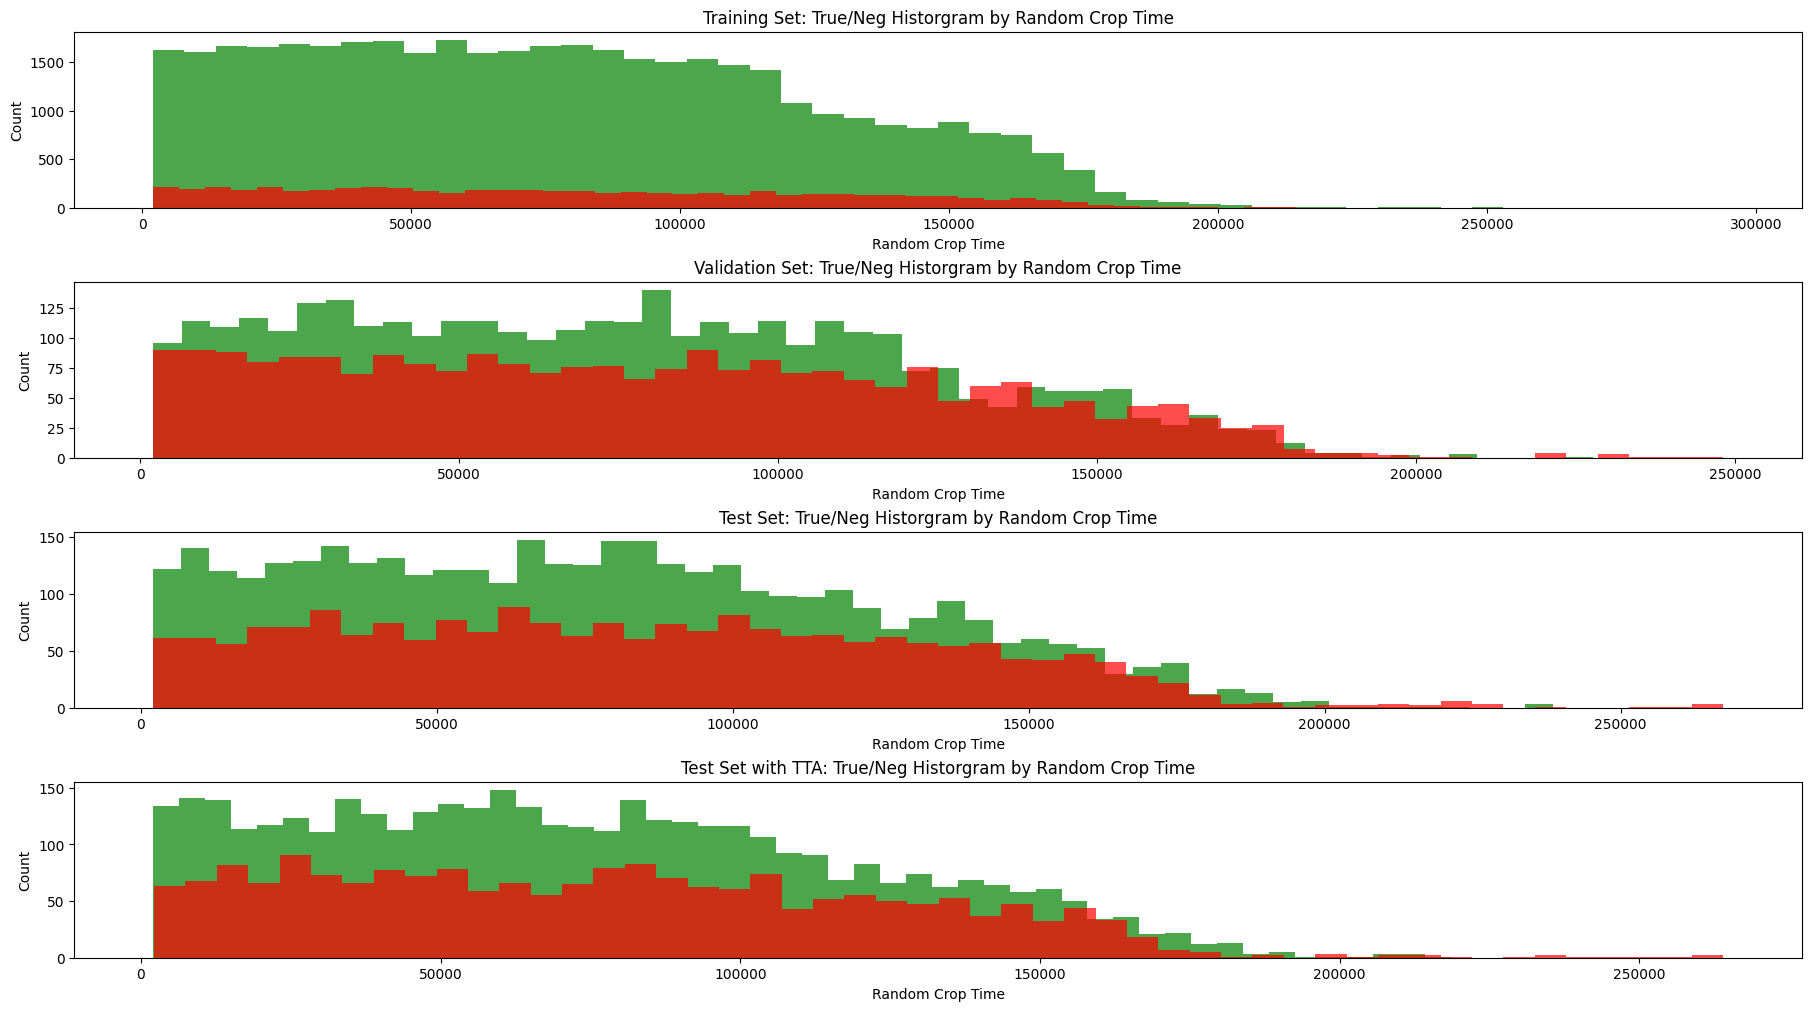

In [19]:
fig = plt.figure(num=1, clear=True, figsize=(18, 10), constrained_layout=True)
n_bins = 50
density = False

ax = fig.add_subplot(4, 1, 1)
ax.hist(train_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(train_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Training Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(4, 1, 2)
ax.hist(val_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(val_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Validation Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(4, 1, 3)
ax.hist(test_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(test_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Test Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(4, 1, 4)
ax.hist(longer_test_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(longer_test_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Test Set with TTA: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

plt.show()
fig.clear()
plt.close(fig)

-----

## Evaluate the model with length limit

### Configurations

In [20]:
config = ckpt['config']

config['crop_timing_analysis'] = False
config['signal_length_limit'] = 200 * 60 * 7  # 7 minutes
config['eval'] = True
config['device'] = device

repeat = round(50 / config['crop_multiple'])

train_loader, val_loader, test_loader, longer_test_loader = build_dataset_for_train(config, verbose=False)

In [21]:
# train
train_acc = check_accuracy(model, train_loader, config['preprocess_test'], config, repeat=repeat)
val_acc = check_accuracy(model, val_loader, config['preprocess_test'], config, repeat=repeat)
test_acc = check_accuracy(model, test_loader, config['preprocess_test'], config, repeat=repeat)
longer_test_acc = check_accuracy(model, longer_test_loader, config['preprocess_test'], config, repeat=repeat)

print(train_acc, val_acc, test_acc, longer_test_acc)

86.9396551724138 58.60504201680672 64.1344537815126 66.25210084033614


## Evaluate using random crop averaging

In [22]:
@torch.no_grad()
def check_accuracy_score_mean(model, loader, preprocess, config, repeat=1):
    model.eval()

    # for accuracy
    correct, total = (0, 0)

    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in loader:
                # preprocessing (this includes to-device operation)
                preprocess(sample_batched)

                # apply model on whole batch directly on device
                x = sample_batched['signal']
                age = sample_batched['age']
                y = sample_batched['class_label']
                output = model(x, age)

                if config['criterion'] == 'cross-entropy':
                    s = F.softmax(output, dim=1)
                elif config['criterion'] == 'multi-bce':
                    s = torch.sigmoid(output)
                
                s = torch.mean(s, dim=0, keepdims=True)
                y = y[0]

                # calculate accuracy
                pred = s.argmax(dim=-1)
                correct += pred.squeeze().eq(y).sum().item()
                total += pred.shape[0]
    
    accuracy = 100.0 * correct / total
    
    return accuracy

In [23]:
config = ckpt['config']

config['crop_timing_analysis'] = False
config['eval'] = True
config.pop('signal_length_limit', None)
config['minibatch'] = 64
config['crop_multiple'] = config['minibatch']
config['device'] = device

repeat = round(50 / config['crop_multiple'])

train_loader, val_loader, test_loader, longer_test_loader = build_dataset_for_train(config, verbose=False)

In [24]:
# train
train_acc = check_accuracy_score_mean(model, train_loader, config['preprocess_test'], config, repeat=repeat)
val_acc = check_accuracy_score_mean(model, val_loader, config['preprocess_test'], config, repeat=repeat)
test_acc = check_accuracy_score_mean(model, test_loader, config['preprocess_test'], config, repeat=repeat)
longer_test_acc = check_accuracy_score_mean(model, longer_test_loader, config['preprocess_test'], config, repeat=repeat)

print(train_acc, val_acc, test_acc, longer_test_acc)

92.52631578947368 58.8235294117647 70.58823529411765 69.74789915966386


## Evaluate using random crop averaging and length limit

In [25]:
config = ckpt['config']

config['crop_timing_analysis'] = False
config['eval'] = True
config['signal_length_limit'] = 200 * 60 * 7  # 7 minutes
config['minibatch'] = 64
config['crop_multiple'] = config['minibatch']
config['device'] = device

repeat = round(50 / config['crop_multiple'])

train_loader, val_loader, test_loader, longer_test_loader = build_dataset_for_train(config, verbose=False)

In [26]:
# train
train_acc = check_accuracy_score_mean(model, train_loader, config['preprocess_test'], config, repeat=repeat)
val_acc = check_accuracy_score_mean(model, val_loader, config['preprocess_test'], config, repeat=repeat)
test_acc = check_accuracy_score_mean(model, test_loader, config['preprocess_test'], config, repeat=repeat)
longer_test_acc = check_accuracy_score_mean(model, longer_test_loader, config['preprocess_test'], config, repeat=repeat)

print(train_acc, val_acc, test_acc, longer_test_acc)

92.52631578947368 57.983193277310924 69.74789915966386 70.58823529411765
